In [ ]:
import numpy as np
import jax.numpy as jnp
from jax import random, vmap, jit

from functools import partial
import scipy
import matplotlib.pyplot as plt
import time

from scipy.io import loadmat
import jax.lax as lax
import jax

from projection import TrajectoryProjector as qp_solver

import os


import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

In [ ]:
# num = 4
# num_batch = 4
# t = 0.05

num_dof=1 
num_steps=100 
num_batch=400 
timestep=0.05 
maxiter_projection=1000
v_max=1.0 
a_max=2.0 
j_max=3.0 
p_max=45.0*np.pi/180.0 
theta_init = 0.0*np.pi/180.0
rho_ineq= 1.0 
rho_projection=1.0 

opt_class = qp_solver(num_dof= num_dof,
                        num_steps=num_steps,
                        num_batch= num_batch,
                        timestep=timestep,
                        maxiter_projection=maxiter_projection,
                        v_max=v_max,
                        a_max=a_max,
                        j_max=j_max,
                        p_max=p_max,
                        theta_init=theta_init,
                        rho_ineq= rho_ineq,
                        rho_projection=rho_projection)

# vel_init = 0.0

# vel_min = -1.2
# vel_max = 1.2

# acc_min = -1.8
# acc_max = 1.8

# jerk_min = -1.8
# jerk_max = 1.8

# vel_samples = np.random.uniform(-1.5, 1.5,  (num_batch, num)    )


In [31]:
# Sample a trajectory
key = jax.random.PRNGKey(42)
xi_samples, _ = opt_class.sample_uniform_trajectories(key)

print(f"Sampled trajectory shape: {xi_samples.shape}")

Sampled trajectory shape: (400, 100)


In [32]:
print(opt_class.A_control.shape)

(794, 100)


In [33]:
# Project the trajectory
xi_filtered_initial_guess = xi_samples
lamda_init = jnp.zeros((opt_class.num_batch, opt_class.nvar))
s_init = jnp.zeros((opt_class.num_batch, opt_class.num_total_constraints))
start_time = time.time()
xi_filtered, prime_residuals, fixed_point_residuals = opt_class.compute_projection(xi_samples, lamda_init, s_init)

print("prime resdiuals", prime_residuals.shape)
print("fixed_point_residuals", fixed_point_residuals.shape)

print(f"Projection time: {time.time() - start_time:.3f} seconds")
    


prime resdiuals (100, 400)
fixed_point_residuals (100, 400)
Projection time: 0.215 seconds


In [34]:

# Convert to numpy for saving/analysis
# xi_np = np.mean(xi_samples, axis=0) 
# xi_filtered_np = np.mean(xi_filtered, axis=0)

xi_np = np.array(xi_samples)
xi_filtered_np = np.array(xi_filtered)
prime_residuals_np = np.array(prime_residuals)
fixed_residuals_np = np.array(fixed_point_residuals)



# Save results
os.makedirs('results', exist_ok=True)
np.savetxt('results/original_trajectory.csv', xi_np, delimiter=',')
np.savetxt('results/projected_trajectory.csv', xi_filtered_np, delimiter=',')
np.savetxt('results/prime_residuals.csv', prime_residuals_np, delimiter=',')
np.savetxt('results/fixed_residuals.csv', fixed_residuals_np, delimiter=',')

print("Generated sample trajectories")
print(f"Original shape: {xi_np.shape}")
print(f"xi_filtered shape: {xi_filtered_np.shape}")
print(f"All residuals shape: {prime_residuals_np.shape}")

Generated sample trajectories
Original shape: (400, 100)
xi_filtered shape: (400, 100)
All residuals shape: (100, 400)


In [35]:
#print("P_pos", opt_class.P_pos)
print("P_pos", opt_class.P_pos.shape)
print("xi_pos", xi_filtered_np.shape)
pos = (np.asarray(opt_class.P_pos) @ xi_filtered_np.T).T +opt_class.theta_init*np.ones((xi_filtered_np.shape[0], opt_class.P_pos.shape[0]))
pos_np = np.asarray(pos)
#print("pos_np", pos_np)

P_pos (100, 100)
xi_pos (400, 100)


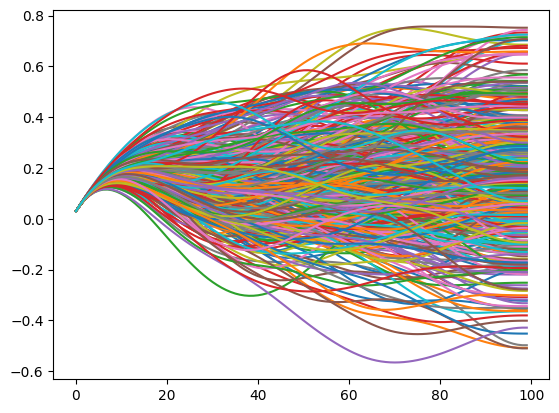

In [36]:
%matplotlib inline
plt.figure(1)
plt.plot(pos_np.T)
plt.show()


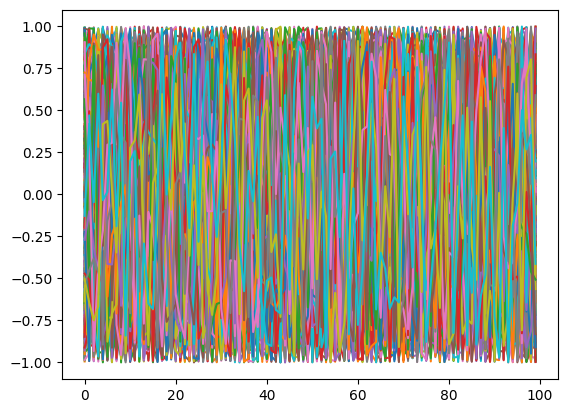

In [37]:
%matplotlib inline
plt.figure(2)
plt.plot(xi_np.T)
plt.show()


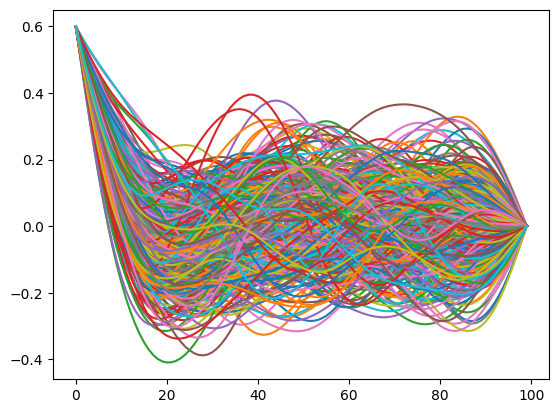

In [38]:

%matplotlib inline
plt.figure(3)
plt.plot(xi_filtered_np.T)
plt.show()

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_trajectory(original, projected, dof_idx=0, dof=1, dt=0.05):
    """Visualize original and residual trajectories separately for a specific DOF"""
    
    num_steps = original.shape[0] // dof
    
    # Extract velocities for the specified DOF
    orig_vel = original[dof_idx*num_steps : (dof_idx+1)*num_steps]
    proj_vel = projected[dof_idx*num_steps : (dof_idx+1)*num_steps]
    
    # Calculate residual velocity (original - projected)
    filtered_vel = proj_vel
    
    # Create time vector
    time = np.arange(num_steps) * dt
    
    # Plot original velocity
    plt.figure(figsize=(10, 4))
    plt.plot(time, orig_vel, 'b-')
    plt.axhline(y=1.0, color='g', linestyle='--', label='v_max')
    plt.axhline(y=-1.0, color='g', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel(f'Joint {dof_idx} Velocity')
    plt.title(f'Original Joint {dof_idx} Velocity')
    plt.legend()
    plt.grid(True)
    try:
        plt.show()
    except:
        plt.savefig(f"original_trajectory_dof{dof_idx}.png")
        print(f"Original plot saved as original_trajectory_dof{dof_idx}.png")
    
    # Plot residual velocity
    plt.figure(figsize=(10, 4))
    plt.plot(time, filtered_vel, 'm-')
    plt.axhline(y=0.0, color='k', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel(f'Joint {dof_idx} Filtered Velocity')
    plt.title(f'Filtered Velocity for Joint {dof_idx}')
    plt.legend()
    plt.grid(True)
    try:
        plt.show()
    except:
        plt.savefig(f"residual_trajectory_dof{dof_idx}.png")
        print(f"Residual plot saved as residual_trajectory_dof{dof_idx}.png")


def visualize_residuals(residuals):
    """Visualize residuals across iterations for a specific batch sample"""
    
    # residuals shape: (maxiter_projection, num_batch)
    # Extract residuals for specific batch sample
    
    residuals_sample = residuals
    
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(residuals_sample, 'b-', marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Residual')
    plt.title(f'ADMM Residuals Convergence )')
    plt.grid(True)
    
    try:
        plt.show()
    except:
        plt.savefig(f"residuals_batch.png")
        print(f"Residuals plot saved as residuals_batch.png")
        


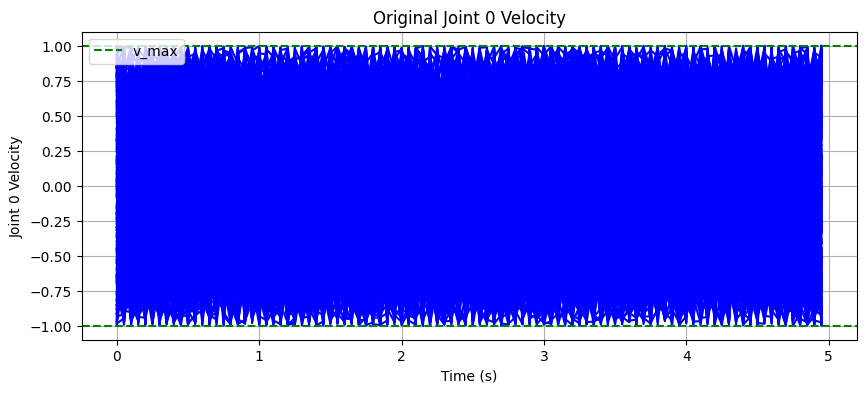

/tmp/ipykernel_1019666/2421631824.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


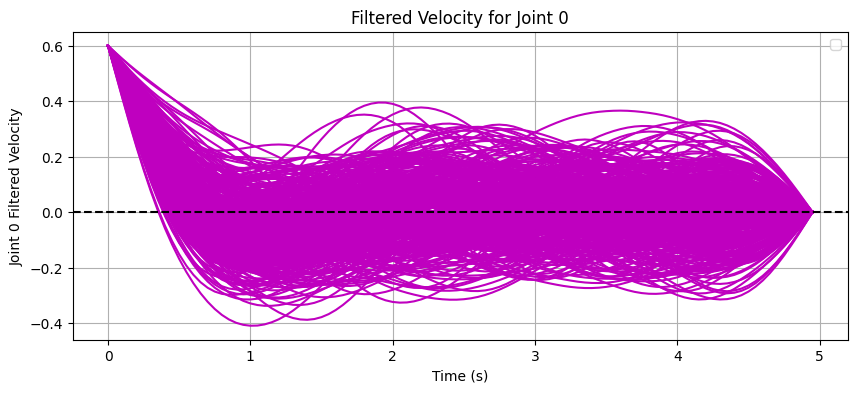

In [40]:
%matplotlib inline
visualize_trajectory(xi_np.T, xi_filtered_np.T, dof_idx=0, dof=1, dt=0.05)


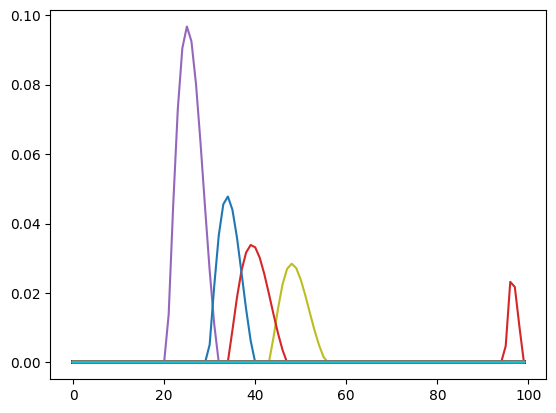

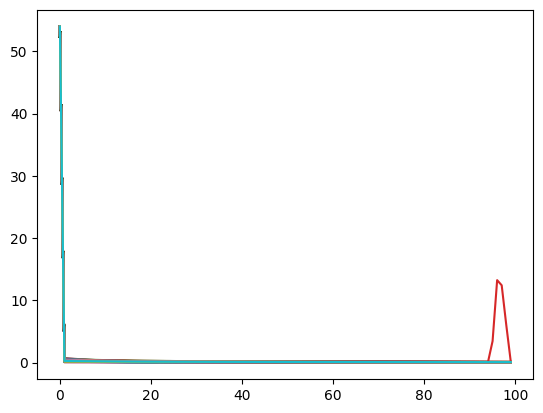

In [41]:
# visualize_residuals(prime_residuals)
# visualize_residuals(fixed_point_residuals)
%matplotlib inline
plt.figure()
plt.plot(prime_residuals)
plt.show()

%matplotlib inline
plt.figure()
plt.plot(fixed_point_residuals)
plt.show()


In [42]:
print('start')
print(f'Max Fixed point residual: {max(fixed_point_residuals[0])}')
print(f'Max Prime residual: {max(prime_residuals[0])}')
print(f'Min Fixed point residual: {min(fixed_point_residuals[0])}')
print(f'Min Prime residual: {min(prime_residuals[0])}')

print('end')
print(f'Max Fixed point residual: {max(fixed_point_residuals[-1])}')
print(f'Max Prime residual: {max(prime_residuals[-1])}')
print(f'Min Fixed point residual: {min(fixed_point_residuals[-1])}')
print(f'Min Prime residual: {min(prime_residuals[-1])}')

start
Max Fixed point residual: 54.00179782537471
Max Prime residual: 0.0
Min Fixed point residual: 53.99584391699979
Min Prime residual: 0.0
end
Max Fixed point residual: 0.10979126425265248
Max Prime residual: 0.0
Min Fixed point residual: 0.022385263217071117
Min Prime residual: 0.0
